# Metrics analysis for all frameworks - Periodic Burst

In [1]:
# selectivity per run. This is required to compute the input throughput
NOTEBOOK_PHASE = 3

if (NOTEBOOK_PHASE == 1):
    inputfactor = 1
elif(NOTEBOOK_PHASE == 2):
    inputfactor = 2
elif(NOTEBOOK_PHASE == 3):
    inputfactor = 3.166667
    
print("Will use input factor: " + str(inputfactor))

In [3]:
# settings for saving plots
saveplots = True
dpiResolution = 200

In [4]:
import pyspark.sql.functions as F
import numpy as np
# Import to indent the plots in the notebook
%matplotlib notebook
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import seaborn as sns
from IPython.core.display import display, HTML
from PIL import Image
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

In [5]:
# Python imports
import pandas as pd 
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import numpy as np
import pytz
import math

# SQL imports
from pyspark.sql.functions import isnan, when, count, col, lead, udf, lag, to_date, avg, desc, sum
from pyspark.sql import Window
from pyspark.sql import functions
from pyspark.sql.types import IntegerType, LongType, DoubleType, TimestampType, StringType

In [6]:
# settings to get plots in the right style
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'lightgrey'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'normal'
plt.rcParams['figure.edgecolor'] = 'lightgrey'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.edgecolor'] = 'lightgrey'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] ='bold'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] ='out'
plt.rcParams["date.autoformatter.minute"] = "%H:%M"
plt.rcParams["font.family"] = "Times New Roman"

In [9]:
spark

In [10]:
# List of which frameworks should be included in this comparison
frameworks_that_could_be_in_the_data = ["FLINK", "KAFKASTREAMS", "SPARK", "STRUCTUREDSTREAMING"]
frameworksPrintable = {
    "SPARK": "Spark Streaming", 
    "STRUCTUREDSTREAMING":"Structured Streaming", 
    "FLINK": "Flink", 
    "KAFKASTREAMS": "Kafka Streams"   
}
stages=["ingest", "parse", "join", "aggregate", "window"]

In [11]:
dataPath = dict()
for i in frameworks_that_could_be_in_the_data:
    dataPath[i] =  "./data/" + i + "/periodic-burst/phase" + str(NOTEBOOK_PHASE) + "/*"

In [72]:
print("The paths that will be read: ")
dataPath

The paths that will be read: 


{'FLINK': './data/FLINK/periodic-burst/phase3/*',
 'KAFKASTREAMS': './data/KAFKASTREAMS/periodic-burst/phase3/*',
 'SPARK': './data/SPARK/periodic-burst/phase3/*',
 'STRUCTUREDSTREAMING': './data/STRUCTUREDSTREAMING/periodic-burst/phase3/*'}

## General Methods

For printing the quantiles of a column:
provide a list of quantiles

In [14]:
def datetimeFromEpoch(epoch):
    return datetime.utcfromtimestamp(epoch//1000).replace(microsecond=epoch%1000*1000)

datetimeFromEpochUDF = functions.udf(datetimeFromEpoch, TimestampType())

In [17]:
def save_img_colored_and_grayscale(path_colored_img):
    if saveplots: 
        plt.savefig(path_colored_img + '.png', dpi=dpiResolution, bbox_inches="tight", pad_inches = 0)
        im = Image.open(path_colored_img + '.png').convert('L')
        im.save(path_colored_img + '_grayscale.png', dpi=(300, 300))

# Latency 
Read in latency data and transform in the right format for plotting.

In [73]:
# Save the data in here
completeResults = defaultdict(dict)

# Save the frameworks present in the data in here
frameworks = ["FLINK", "KAFKASTREAMS", "SPARK", "STRUCTUREDSTREAMING"]
frameworks_per_phase = ["FLINK", "KAFKASTREAMS", "SPARK", "STRUCTUREDSTREAMING"]

In [20]:
# Save the frameworks present in the data in here
containerCheck = defaultdict(dict)
for framework in frameworks:
    requiredAmtContainers = 5 if framework == "KAFKASTREAMS" else 5
    containerCheckPhase = spark.read.option("header", "true").option("inferSchema", "true") \
    .csv(dataPath[framework] + "/resources-per-container-timeseries.csv/*")
    amtOfContainers = containerCheckPhase.select("containerName").distinct().count()
    if amtOfContainers != requiredAmtContainers:
        print("WARNING FOR " + framework + " volume: " + str(NOTEBOOK_PHASE) + " amount of containers: " + str(amtOfContainers))
    else:
        print("all checks passed")

WARNING FOR FLINK volume: 3 amount of containers: 6
all checks passed
all checks passed
all checks passed


Phases that are present in the data

In [21]:
latencyTimeseriesDataWithStartup = dict()
for framework in frameworks:
    latencyTimeseriesDataPhase = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/latency-timeseries-data-without-startup.csv/*") \
        .withColumn("time", datetimeFromEpochUDF(col("outputBucketTime")))

    minTimeSec = int(latencyTimeseriesDataPhase.select("startTime").collect()[0][0]) / 60000
    latencyTimeseriesDataWithStartup[framework] = latencyTimeseriesDataPhase.withColumn("timeSec", (col("outputBucketTime")/60000.0)-minTimeSec)


In [22]:
latencyTimeseriesDataWithoutStartup = defaultdict(dict)
for framework in frameworks:
    latencyTimeseriesDataPhase = latencyTimeseriesDataWithStartup[framework] 
    startTime = latencyTimeseriesDataPhase.agg(F.min("outputBucketTime")).collect()[0][0]
    latencyWithoutStartup = latencyTimeseriesDataPhase.filter(col("outputBucketTime")>startTime + 120000)
    latencyTimeseriesDataWithoutStartup[framework] = latencyWithoutStartup

# Throughput

## Stage 0 throughput

In [24]:
throughputTimeseriesDataWithStartup = dict()
for framework in frameworks:
    throughputTimeseriesDataWithStartupPhase = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/output-throughput-timeseries-second-buckets.csv/*") \
        .withColumn("time", datetimeFromEpochUDF(col("outputBucketTime")))    

    minTimeSec = int(throughputTimeseriesDataWithStartupPhase.select("startTime").collect()[0][0]) / 60000
    throughputTimeseriesDataWithStartup[framework] = throughputTimeseriesDataWithStartupPhase.withColumn("timeSec", (col("outputBucketTime")/60000.0)-minTimeSec)

inputThroughputTimeseriesDataWithStartup = dict()
for framework in frameworks:
    inputThroughputTimeseriesDataWithStartupPhase = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/input-throughput-timeseries-second-buckets.csv/*") \
        .withColumn("time", datetimeFromEpochUDF(col("inputBucketTime")))    

    minTimeSec = int(inputThroughputTimeseriesDataWithStartupPhase.select("startTime").collect()[0][0]) / 60000
    inputThroughputTimeseriesDataWithStartup[framework] = inputThroughputTimeseriesDataWithStartupPhase.withColumn("timeSec", (col("inputBucketTime")/60000.0)-minTimeSec)


In [25]:
throughputTimeseriesDataWithoutStartup = dict()
for framework in frameworks:
    throughputTimeseriesDataPhase = throughputTimeseriesDataWithStartup[framework]
    startTime = throughputTimeseriesDataPhase.agg(F.min("outputBucketTime")).collect()[0][0]
    throughputWithoutStartup = throughputTimeseriesDataPhase \
        .filter(col("outputBucketTime")>startTime + 120000)
    throughputTimeseriesDataWithoutStartup[framework] = throughputWithoutStartup              

# CPU 

In [27]:
cpuTimeseries = dict()
for framework in frameworks:
    try:
        cpuTimeseries[framework] = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[framework] + "/cpu-per-container-timeseries.csv/*") \
            .withColumn("timeParsed", datetimeFromEpochUDF(col("time")))
    except:
        print("didnt work for " + framework)

In [28]:
containersPandas = dict()
for framework in frameworks:
    containersPandas[framework] = cpuTimeseries[framework].select("containerName").distinct().toPandas()

In [29]:
# Map label to RGB
color_map = dict()
for framework in frameworks:
    #Assign different color to each container
    rgb_values = sns.diverging_palette(255, 133, l=60, n=len(containersPandas[framework]), center="dark")
    color_map[framework] = dict(zip(containersPandas[framework]['containerName'], rgb_values))

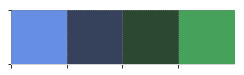

In [30]:
sns.palplot(sns.diverging_palette(255, 133, l=60, n=len(containersPandas), center="dark"))

In [31]:
# Map label to RGB
color_map = defaultdict(dict)
for framework in frameworks:
    #Assign different color to each container:
    rgb_values = sns.husl_palette(len(containersPandas[framework]), h=0.4, l=0.65, s=1) 
    color_map[framework] = dict(zip(containersPandas[framework]['containerName'], rgb_values))

## CPU usage distribution

In [32]:
workerCpuTimeseriesDataWithStartup = dict()
for framework in frameworks:
    workerCpuTimeseriesDataWithStartup[framework] = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/cpu-total-timeseries.csv/*") \
        .withColumn("time", datetimeFromEpochUDF(col("outputKafkaTimestampFiveSecondBucket")))

## CPU timeseries analysis

In [33]:
workerCpuTimeseriesDataWithStartup = dict()
for framework in frameworks:
    cpuTimeseriesPerContainerPhase = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/cpu-total-timeseries.csv/*") \
        .withColumn("time", datetimeFromEpochUDF(col("outputKafkaTimestampFiveSecondBucket")))

    minTimeSec = int(cpuTimeseriesPerContainerPhase.select("startTime").collect()[0][0]) / 60000
    workerCpuTimeseriesDataWithStartup[framework] = cpuTimeseriesPerContainerPhase.withColumn("timeSec", (col("outputKafkaTimestampFiveSecondBucket")/60000.0)-minTimeSec)          

In [34]:
workerCpuTimeseriesDataWithoutStartup = dict()
for framework in frameworks:
    cpuTimeseriesDataPhase = workerCpuTimeseriesDataWithStartup[framework]
    if len(cpuTimeseriesDataPhase.head(1)) > 0:
        startTime = cpuTimeseriesDataPhase.agg(F.min("outputKafkaTimestampFiveSecondBucket")).collect()[0][0]
        cpuWithoutStartup = cpuTimeseriesDataPhase \
            .filter(col("outputKafkaTimestampFiveSecondBucket")>startTime + 120000)

        minTimeSec = int(cpuWithoutStartup.select("startTime").collect()[0][0]) / 60000
        workerCpuTimeseriesDataWithoutStartup[framework] = cpuWithoutStartup.withColumn("timeSec", (col("outputKafkaTimestampFiveSecondBucket")/60000.0)-minTimeSec)          
    else:
        print("No data for stage " + str(i))

In [35]:
cpuTimeseriesDataWithStartup = dict()
for framework in frameworks:
    cpuOfPhasePerContainer = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/cpu-per-container-timeseries.csv/*") \
        .withColumn("timeParsed", datetimeFromEpochUDF(col("time")))

    minTimeSec = int(cpuOfPhasePerContainer.select("startTime").collect()[0][0]) / 60000
    cpuTimeseriesDataWithStartup[framework] = cpuOfPhasePerContainer \
        .withColumn("timeSec", (col("time")/60000.0)-minTimeSec)
cpuTimeseriesDataWithoutStartup = dict()
for framework in frameworks:  
    cpuTimeseriesDataPhase = cpuTimeseriesDataWithStartup[framework]
    if len(cpuTimeseriesDataPhase.head(1)) > 0:
        startTime = cpuTimeseriesDataPhase.agg(F.min("time")).collect()[0][0]
        cpuWithoutStartup = cpuTimeseriesDataPhase \
            .filter(col("time")>startTime + 120000)

        minTimeSec = int(cpuTimeseriesDataPhase.select("startTime").collect()[0][0]) / 60000
        cpuTimeseriesDataWithoutStartup[framework] = cpuWithoutStartup \
            .withColumn("timeSec", (col("time")/60000.0)-minTimeSec)
    else:
        print("No data for stage " + str(i))

In [36]:
cpuDistributionPerContainer = dict()
for framework in frameworks:
    cpuDistributionPerContainer[framework] = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/cpuUsagePct-histogram-with-startup-per-container.csv/*")\
        .orderBy("cpuUsagePctBucket")
containersPandasPerPhase = dict()
for framework in frameworks:
    containersPandasPerPhase[framework] = cpuDistributionPerContainer[framework] \
        .select("containerName").distinct().orderBy("containerName").toPandas()

# Memory 

## Memory Distribution

In [37]:
workerMemoryTimeseriesDataWithStartup = dict()
for framework in frameworks: 
        memoryTimeseriesTotalPhase = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[framework] + "/resources-total-timeseries.csv/*") \
            .withColumn("time", datetimeFromEpochUDF(col("outputKafkaTimestampFiveSecondBucket")))

        minTimeSec = int(memoryTimeseriesTotalPhase.select("startTime").collect()[0][0]) / 60000
        workerMemoryTimeseriesDataWithStartup[framework] = memoryTimeseriesTotalPhase.withColumn("timeSec", (col("outputKafkaTimestampFiveSecondBucket")/60000.0)-minTimeSec)

In [38]:
workerMemoryTimeseriesDataWithStartup = dict()
for framework in frameworks:
    memoryTimeseriesTotalPhase = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/resources-total-timeseries.csv/*") \
        .withColumn("time", datetimeFromEpochUDF(col("outputKafkaTimestampFiveSecondBucket")))

    minTimeSec = int(memoryTimeseriesTotalPhase.select("startTime").collect()[0][0]) / 60000
    workerMemoryTimeseriesDataWithStartup[framework] = memoryTimeseriesTotalPhase.withColumn("timeSec", (col("outputKafkaTimestampFiveSecondBucket")/60000.0)-minTimeSec)
workerMemoryTimeseriesDataWithoutStartup = dict()
for framework in frameworks:
    memoryTimeseriesDataPhase = workerMemoryTimeseriesDataWithStartup[framework]
    if len(memoryTimeseriesDataPhase.head(1)) > 0:
        startTime = int(memoryTimeseriesDataPhase.agg(F.min("outputKafkaTimestampFiveSecondBucket")).collect()[0][0])
        memoryWithoutStartup = memoryTimeseriesDataPhase \
            .filter(col("outputKafkaTimestampFiveSecondBucket")>startTime + 120000)

        minTimeSec = int(memoryWithoutStartup.select("startTime").collect()[0][0]) / 60000
        workerMemoryTimeseriesDataWithoutStartup[framework] = memoryWithoutStartup.withColumn("timeSec", (col("outputKafkaTimestampFiveSecondBucket")/60000.0)-minTimeSec)
    else:
        print("No data for stage " + str(i))

In [39]:
memoryTimeseriesDataWithStartup = dict()
for framework in frameworks:
    memoryTimeseriesPerContainerAndPhase = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/resources-per-container-timeseries.csv") \
        .withColumn("timeParsed", datetimeFromEpochUDF(col("time")))

    minTimeSec = memoryTimeseriesPerContainerAndPhase.select("startTime").collect()[0][0] / 60000
    memoryTimeseriesDataWithStartup[framework] = memoryTimeseriesPerContainerAndPhase.withColumn("timeSec", (col("time")/60000.0)-minTimeSec)


memoryTimeseriesDataWithoutStartup = dict()
for framework in frameworks:
    memoryTimeseriesDataPhase = memoryTimeseriesDataWithStartup[framework]
    if len(memoryTimeseriesDataPhase.head(1)) > 0:
        startTime = memoryTimeseriesDataPhase.agg(F.min("time")).collect()[0][0]
        memoryWithoutStartup = memoryTimeseriesDataPhase \
            .filter(col("time")>startTime + 120000)

        minTimeSec = memoryTimeseriesDataPhase.select("startTime").collect()[0][0] / 60000
        memoryTimeseriesDataWithoutStartup[framework]= memoryWithoutStartup.withColumn("timeSec", (col("time")/60000.0)-minTimeSec)

    else:
        print("No data for stage " + str(i))

# Metric correlations
Plotting different metrics for a certain stage together.

For generating a chart of the four metrics

In [47]:
def generatePeriodicBurstChart(colNum, containersPandas, latencyPandas, throughputPandas, inputThroughputPandas, memoryPandas, cpuPandas, start, end):
    minor_x_locator = AutoMinorLocator(3) # how many minor grid lines in between two major grid lines for x axis
    
    pct01_line, = ax[0, colNum].plot(latencyPandas["timeSec"], latencyPandas["percentile_01_second"], color="#a8a8a8", linestyle="--", label = "1p")
    pct50_line, = ax[0, colNum].plot(latencyPandas["timeSec"], latencyPandas["percentile_50_second"], color="#7e7e7e", linestyle="solid", label = "50p")
    pct99_line, = ax[0, colNum].plot(latencyPandas["timeSec"], latencyPandas["percentile_99_second"], color="#151515", linestyle="solid", label = "99p")
    ax[0, colNum].set_ylim(ymin=0, ymax=5300)
    ax[0, colNum].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_1 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[0, colNum].yaxis.set_minor_locator(minor_y_locator_1)
    ax[0, colNum].set_yticks([0, 2000, 4000])
    ax[0, colNum].grid(which='minor', color='black')
    ax[0, colNum].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ') + " s"))
    
    tp_line1, = ax[1, colNum].plot(throughputPandas["timeSec"], throughputPandas["outputMsgCount"], label = "output", color="#151515", linestyle="solid")
    tp_line2, = ax[1, colNum].plot(inputThroughputPandas["timeSec"], inputThroughputPandas["inputMsgCount"].multiply(inputfactor), label = "input", color="#7e7e7e", linestyle = "--")
    ax[1, colNum].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ')))
    ax[1, colNum].set_ylim(ymin=0, ymax=40000)
    ax[1, colNum].xaxis.set_minor_locator(minor_x_locator)
    ax[1, colNum].set_yticks([0, 20000, 40000])
    ax[1, colNum].grid(which='minor', color='black')
    

    cpuTimeseriesDataWithStartupPhase = cpuTimeseriesDataWithStartup[framework]\
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()
    for contNum, containerId in enumerate(containersPandasPerPhase[framework]['containerName']):
        if "FLINK" in framework: label = "taskmanager-" + str(contNum)
        else: label = containerId
        data = cpuTimeseriesDataWithStartupPhase.loc[cpuTimeseriesDataWithStartupPhase['containerName'] == containerId]
        cpu_worker_line, = ax[2, colNum].plot(data['timeSec'], data['cpuUsagePct'], 
               c="black", linestyle=":", label="cpu usage worker")

    ax[2, colNum].set_ylim(ymin=0, ymax=110)
    ax[2, colNum].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[2, colNum].yaxis.set_minor_locator(minor_y_locator_3)
    ax[2, colNum].grid(which='minor', color='black')
    ax[2, colNum].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x)) + " %"))

    mem_line1, = ax[3, colNum].plot(memoryPandas['timeSec'], memoryPandas['totalAvgMemUsageMB'], color="#7e7e7e", linestyle="solid", label = "average heap memory")
    mem_line2, = ax[3, colNum].plot(memoryPandas['timeSec'], memoryPandas['totalMaxMemUsageMB'], color="#151515", linestyle="solid", label = "max heap memory")
    
    sortedDf = memoryTimeseriesDataWithStartup[framework].orderBy("timeSec") \
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()
    # Add a color column that gives color to the dots
    for contNum, containerId in enumerate(containersPandasPerPhase[framework]['containerName']):
        if "FLINK" in framework: label = "taskmanager-" + str(contNum)
        else: label = containerId
        data = sortedDf.loc[sortedDf['containerName'] == containerId]
        mem_worker_line, = ax[3, colNum].plot(data['timeSec'], 
             data['heapUsageMB'], 
             c="black", linestyle=":", label="heap workers")
    
    ax[3, colNum].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1024.0), ',').replace(',', ' ') + " GB"))
    ax[3, colNum].set_xlabel("minutes")
    ax[3, colNum].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_4 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[3, colNum].yaxis.set_minor_locator(minor_y_locator_4)
    ax[3, colNum].grid(which='minor', color='black')
    ax[3, colNum].set_yticks([0, 10*1024])
    

    if (colNum == 0):
        ax[0, colNum].set_ylabel("latency")
        ax[1, colNum].set_ylabel("throughput\nx1000 msg/s")
        ax[2, colNum].set_ylabel("CPU")
        ax[3, colNum].set_ylabel("mem")
    
    if (colNum == len(frameworks)-1):
        ax[0, colNum].legend(loc = "upper right", ncol=3, bbox_to_anchor=(1, 1.55), framealpha=1.0, frameon=False)
        ax[1, colNum].legend(loc = "upper right", ncol=2, bbox_to_anchor=(1, 1.60), framealpha=0.5, frameon=False)
        ax[2, colNum].legend([cpu_worker_line], ["per worker"], loc = "upper right", bbox_to_anchor=(1, 1.55), frameon=False)
        ax[3, colNum].legend([mem_line1, mem_line2, mem_worker_line], ["average", "max", "per worker"], loc = "upper right", ncol=3, bbox_to_anchor=(1, 1.55), frameon=False)

In [48]:
stageLatencyPandasShortSample = dict()
stageThroughputPandasShortSample = dict()
stageInputThroughputPandasShortSample = dict()
stageCpuPandasShortSample = dict()
stageMemoryPandasShortSample = dict()
stageRxPandasShortSample = dict()
stageTxPandasShortSample = dict()
start = 15
end = 16
for j, framework in enumerate(frameworks):
    print(framework)
    stageLatencyPandasShortSample[framework] = latencyTimeseriesDataWithoutStartup[framework].orderBy("timeSec") \
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()
    stageThroughputPandasShortSample[framework] = throughputTimeseriesDataWithoutStartup[framework].orderBy("timeSec") \
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()
    stageInputThroughputPandasShortSample[framework] = inputThroughputTimeseriesDataWithStartup[framework].orderBy("timeSec") \
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()
    stageCpuPandasShortSample[framework] = workerCpuTimeseriesDataWithoutStartup[framework].orderBy("timeSec") \
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()
    stageMemoryPandasShortSample[framework] = workerMemoryTimeseriesDataWithoutStartup[framework].orderBy("timeSec") \
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()
    stageRxPandasShortSample[framework] = workerRxTimeseriesDataWithoutStartup[framework].orderBy("timeSec") \
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()
    stageTxPandasShortSample[framework] = workerTxTimeseriesDataWithoutStartup[framework].orderBy("timeSec") \
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()

FLINK
KAFKASTREAMS
SPARK
STRUCTUREDSTREAMING


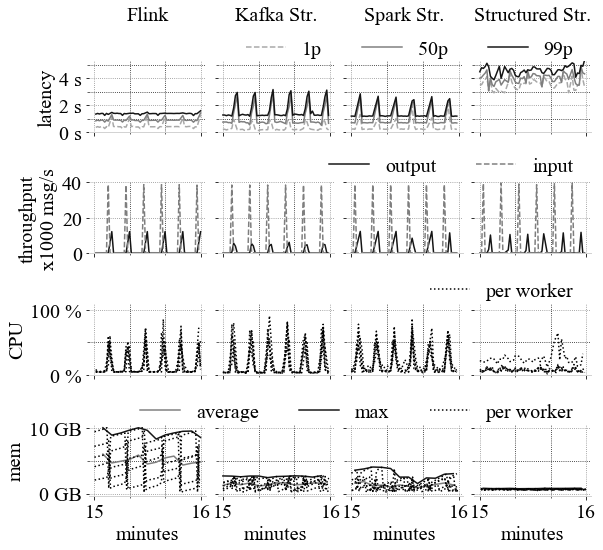

In [49]:
frameworks=["FLINK", "KAFKASTREAMS", "SPARK", "STRUCTUREDSTREAMING"]
frameworksPrintable2 = {
    "SPARK": "Spark Str.", 
    "STRUCTUREDSTREAMING":"Structured Str.", 
    "FLINK": "Flink", 
    "KAFKASTREAMS": "Kafka Str."   
}
f, ax = plt.subplots(4, len(frameworks),figsize=(9, 8), sharey='row', sharex='col')
pad = 5

# for axis, stage in zip(ax[:,0], ['Latency', 'Throughput', 'CPU', 'Memory']):
#     axis.annotate(stage, xy=(0, 0.5), xytext=(-axis.yaxis.labelpad - pad, 0),
#                 xycoords=axis.yaxis.label, textcoords='offset points',
#                 size='medium', ha='right', va='center', rotation='vertical')

for j, framework in enumerate(frameworks):
    generatePeriodicBurstChart(j, containersPandas=containersPandas, \
                           latencyPandas=stageLatencyPandasShortSample[framework], \
                           throughputPandas=stageThroughputPandasShortSample[framework], \
                           inputThroughputPandas=stageInputThroughputPandasShortSample[framework], \
                           cpuPandas=stageCpuPandasShortSample[framework], \
                           memoryPandas=stageMemoryPandasShortSample[framework], start=start, end=end)
    ax[0, j].annotate(frameworksPrintable2[framework], xy=(0.5, 1.5), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            size='medium', ha='center', va='baseline')

plt.subplots_adjust(wspace=0.1, hspace=0.70)
save_img_colored_and_grayscale("./figures/periodic-burst/overall/phase" + str(NOTEBOOK_PHASE) + "/periodicBurstMetricsOverview_phase" + str(NOTEBOOK_PHASE))
plt.show()

In [50]:
def generateLatencyTPChart(colNum, containersPandas, latencyPandas, throughputPandas, inputThroughputPandas, start, end):
    minor_x_locator = AutoMinorLocator(3) # how many minor grid lines in between two major grid lines for x axis
    
    pct01_line, = ax[0, colNum].plot(latencyPandas["timeSec"], latencyPandas["percentile_01_second"], color="#a8a8a8", linestyle="--", label = "1p")
    pct50_line, = ax[0, colNum].plot(latencyPandas["timeSec"], latencyPandas["percentile_50_second"], color="#7e7e7e", linestyle="solid", label = "50p")
    pct99_line, = ax[0, colNum].plot(latencyPandas["timeSec"], latencyPandas["percentile_99_second"], color="#151515", linestyle="solid", label = "99p")
    ax[0, colNum].set_ylim(ymin=0, ymax=5300)
    ax[0, colNum].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_1 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[0, colNum].yaxis.set_minor_locator(minor_y_locator_1)
    ax[0, colNum].set_yticks([0, 2000, 4000])
    ax[0, colNum].grid(which='minor', color='black')
    ax[0, colNum].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ') + " s"))
    
    tp_line1, = ax[1, colNum].plot(throughputPandas["timeSec"], throughputPandas["outputMsgCount"], label = "output", color="#151515", linestyle="solid")
    tp_line2, = ax[1, colNum].plot(inputThroughputPandas["timeSec"], inputThroughputPandas["inputMsgCount"].multiply(inputfactor), label = "input", color="#7e7e7e", linestyle = "--")
    ax[1, colNum].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ')))
    ax[1, colNum].set_ylim(ymin=0, ymax=41000)
    ax[1, colNum].xaxis.set_minor_locator(minor_x_locator)
    ax[1, colNum].set_yticks([0, 20000, 40000])
    ax[1, colNum].grid(which='minor', color='black')
    

    if (colNum == 0):
        ax[0, colNum].set_ylabel("latency")
        ax[1, colNum].set_ylabel("throughput\nx1000 msg/s")
    
    if (colNum == len(frameworks)-1):
        ax[0, colNum].legend(loc = "upper right", ncol=3, bbox_to_anchor=(1, 1.55), framealpha=1.0, frameon=False)
        ax[1, colNum].legend(loc = "upper right", ncol=2, bbox_to_anchor=(1, 1.60), framealpha=0.5, frameon=False)


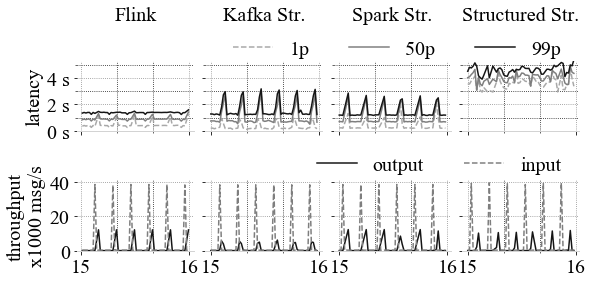

In [51]:
frameworks=["FLINK", "KAFKASTREAMS", "SPARK", "STRUCTUREDSTREAMING"]
frameworksPrintable2 = {
    "SPARK": "Spark Str.", 
    "STRUCTUREDSTREAMING":"Structured Str.", 
    "FLINK": "Flink", 
    "KAFKASTREAMS": "Kafka Str."   
}
f, ax = plt.subplots(2, len(frameworks),figsize=(9, 3.5), sharey='row', sharex='col')
pad = 5

for j, framework in enumerate(frameworks):
    generateLatencyTPChart(j, containersPandas=containersPandas, \
                           latencyPandas=stageLatencyPandasShortSample[framework], \
                           throughputPandas=stageThroughputPandasShortSample[framework], \
                           inputThroughputPandas=stageInputThroughputPandasShortSample[framework], \
                            start=start, end=end)
    ax[0, j].annotate(frameworksPrintable2[framework], xy=(0.5, 1.5), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            size='medium', ha='center', va='baseline')

plt.subplots_adjust(wspace=0.1, hspace=0.70)
save_img_colored_and_grayscale("./figures/periodic-burst/overall/phase" + str(NOTEBOOK_PHASE) + "/periodicReduced_phase" + str(NOTEBOOK_PHASE))
plt.show()

# stats


FLINK
+-----+-----------+
|burst|avgMsgCount|
+-----+-----------+
|    0|      137.0|
|    1|    11169.0|
|    2|     3508.0|
|    3|      125.0|
|    4|      124.0|
|    5|      124.0|
|    6|      126.0|
|    7|      127.0|
|    8|      128.0|
+-----+-----------+

+-----+--------------------+--------------------+
|burst|percentile_50_second|percentile_99_second|
+-----+--------------------+--------------------+
|    0|               907.0|              1415.0|
|    1|              1241.0|              1479.0|
|    2|              1128.0|              1450.0|
|    3|               925.0|              1422.0|
|    4|               925.0|              1425.0|
|    5|               929.0|              1428.0|
|    6|               925.0|              1423.0|
|    7|               906.0|              1406.0|
|    8|               890.0|              1389.0|
+-----+--------------------+--------------------+

KAFKASTREAMS
+-----+-----------+
|burst|avgMsgCount|
+-----+-----------+
|    0|  

/home/giselle-klarrio/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


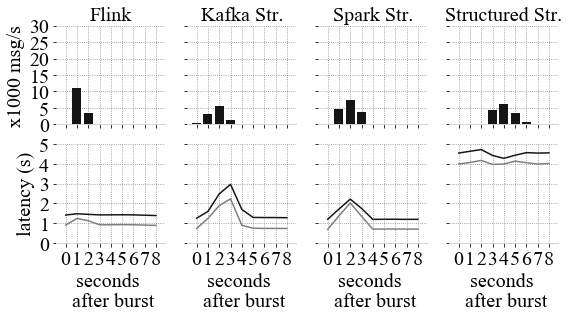

In [56]:
f, ax = plt.subplots(2, len(frameworks),figsize=(9, 4), sharey='row', sharex='col')
file = open("./figures/periodic-burst/overall/phase" + str(NOTEBOOK_PHASE) + "/stats_phase" + str(NOTEBOOK_PHASE) + ".txt", 'w')
for i, framework in enumerate(frameworks):
    print(framework)
    file.write(framework + "\n")
    inputBurstsColumn = inputThroughputTimeseriesDataWithStartup[framework].withColumn("realInputMsgCount",col("inputMsgCount")*inputfactor)\
        .filter(col("realInputMsgCount")>400).select("inputBucket")
    
    afterBurstsColumn1 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 1000).withColumn("burst", F.lit(1))
    afterBurstsColumn2 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 2000).withColumn("burst", F.lit(2))   
    afterBurstsColumn3 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 3000).withColumn("burst", F.lit(3))
    afterBurstsColumn4 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 4000).withColumn("burst", F.lit(4))
    afterBurstsColumn5 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 5000).withColumn("burst", F.lit(5))
    afterBurstsColumn6 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 6000).withColumn("burst", F.lit(6))
    afterBurstsColumn7 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 7000).withColumn("burst", F.lit(7))
    afterBurstsColumn8 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 8000).withColumn("burst", F.lit(8))
    
    timestampsOfInterest = inputBurstsColumn.withColumn("burst", F.lit(0))\
        .union(afterBurstsColumn1)\
        .union(afterBurstsColumn2)\
        .union(afterBurstsColumn3)\
        .union(afterBurstsColumn4)\
        .union(afterBurstsColumn5)\
        .union(afterBurstsColumn6)\
        .union(afterBurstsColumn7)\
        .union(afterBurstsColumn8).orderBy("inputBucket").withColumnRenamed("inputBucket", "outputBucketTime")
        
    outputTpAfterBurst = throughputTimeseriesDataWithStartup[framework].join(timestampsOfInterest, "outputBucketTime")
    outputTpStats = outputTpAfterBurst.groupBy("burst").agg(F.avg("outputMsgCount").alias("avgMsgCount"))\
        .withColumn("avgMsgCount",  F.round(col("avgMsgCount")))\
        .orderBy("burst")
    outputTpStats.show()
    file.write(outputTpStats.toPandas().to_string(header = True, index = False) + "\n")
    outputTpPd = outputTpStats.toPandas()
    
    ax[0, i].bar(outputTpPd["burst"], outputTpPd["avgMsgCount"], color="#151515")
    ax[0, i].set_ylim(ymin=0, ymax=30000)
#     minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
#     ax[0, i].yaxis.set_minor_locator(minor_y_locator_3)
    ax[0, i].grid(which='minor', color='black')
    ax[0, i].set_yticks([0, 5000, 10000, 15000, 20000, 25000, 30000])
    ax[0, i].set_xticks(np.arange(9))
    ax[0, i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ')))
        
    latencyAfterBurst = latencyTimeseriesDataWithStartup[framework].join(timestampsOfInterest, "outputBucketTime")
    latencyStats = latencyAfterBurst.groupBy("burst").agg(F.avg("percentile_50_second").alias("percentile_50_second"), avg("percentile_99_second").alias("percentile_99_second"))\
        .withColumn("percentile_50_second", F.round(col("percentile_50_second")))\
        .withColumn("percentile_99_second", F.round(col("percentile_99_second")))\
        .orderBy("burst")
    latencyPd = latencyStats.toPandas()
    latencyStats.show()
    file.write(latencyPd.to_string(header = True, index = False) + "\n")
    
    ax[1, i].plot(latencyPd["burst"], latencyPd["percentile_50_second"], color="#7e7e7e")
    ax[1, i].plot(latencyPd["burst"], latencyPd["percentile_99_second"], color="#151515")
    ax[1, i].set_xlabel("seconds \n after burst")
    ax[1, i].set_ylim(ymin=0, ymax=5000)
#     minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
#     ax[1, i].yaxis.set_minor_locator(minor_y_locator_3)
    ax[1, i].grid(which='minor', color='black')
    ax[1, i].set_yticks([0, 1000, 2000, 3000, 4000, 5000])
    ax[1, i].set_xticks(np.arange(9))
    ax[1, i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ')))

    ax[0, i].annotate(frameworksPrintable2[framework], xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='medium', ha='center', va='baseline')
ax[0, 0].set_ylabel("x1000 msg/s")  
ax[1, 0].set_ylabel("latency (s)") 
save_img_colored_and_grayscale("./figures/periodic-burst/overall/phase" + str(NOTEBOOK_PHASE) + "/averageburst-phase" + str(NOTEBOOK_PHASE))
f.show()
 
file.close()

12 percent of the events for kafka streams are discarded

## Analysis for different windows

In [57]:
def generateFlinkWindowingPeriodicBurstChart(colNum, latencyPandas, start, end):
    f, ax = plt.subplots(1, 1,figsize=(2.2,2), sharey='row', sharex='col')
    pad = 5
    minor_x_locator = AutoMinorLocator(3) # how many minor grid lines in between two major grid lines for x axis
    
    pct01_line, = ax.plot(latencyPandas["timeSec"], latencyPandas["percentile_01_second"], color="#a8a8a8", linestyle="--", label = "1p")
    pct50_line, = ax.plot(latencyPandas["timeSec"], latencyPandas["percentile_50_second"], color="#7e7e7e", linestyle="solid", label = "50p")
    pct99_line, = ax.plot(latencyPandas["timeSec"], latencyPandas["percentile_99_second"], color="#151515", linestyle="solid", label = "99p")
    ax.set_ylim(ymin=0, ymax=3500)
    ax.xaxis.set_minor_locator(minor_x_locator)
#     minor_y_locator_1 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
#     ax.yaxis.set_minor_locator(minor_y_locator_1)
    ax.set_yticks([0, 1000, 2000, 3000])
    ax.grid(which='minor', color='black')
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ') + " s"))

    ax.set_ylabel("latency")
    ax.set_xlabel("minutes")
    
#     ax.legend(loc = "upper right", ncol=3, bbox_to_anchor=(1, 1.55), framealpha=1.0, frameon=False)
        
    plt.subplots_adjust(wspace=0.1, hspace=0.70)
    save_img_colored_and_grayscale("./figures/periodic-burst/windowing/phase" + str(NOTEBOOK_PHASE) + "/" + framework +"-" + windowType + "-periodic-burst-phase" + str(NOTEBOOK_PHASE))
    plt.show()


In [58]:
windowTypes = ["customwindows", "normalwindows"]

In [59]:
dataPathWindows = defaultdict(dict)
for framework in ["FLINK", "KAFKASTREAMS", "STRUCTUREDSTREAMING"]:
    for windowtype in windowTypes:
        dataPathWindows[framework][windowtype] =  "./data/" + framework + "/periodic-burst/phase" + str(NOTEBOOK_PHASE) + "/" + windowtype + "/*"

In [60]:
dataPathWindows

defaultdict(dict,
            {'FLINK': {'customwindows': './data/FLINK/periodic-burst/phase3/customwindows/*',
              'normalwindows': './data/FLINK/periodic-burst/phase3/normalwindows/*'},
             'KAFKASTREAMS': {'customwindows': './data/KAFKASTREAMS/periodic-burst/phase3/customwindows/*',
              'normalwindows': './data/KAFKASTREAMS/periodic-burst/phase3/normalwindows/*'},
             'STRUCTUREDSTREAMING': {'customwindows': './data/STRUCTUREDSTREAMING/periodic-burst/phase3/customwindows/*',
              'normalwindows': './data/STRUCTUREDSTREAMING/periodic-burst/phase3/normalwindows/*'}})

In [61]:
flinkWindowingLatency = defaultdict(dict)
for framework in ["FLINK", "KAFKASTREAMS", "STRUCTUREDSTREAMING"]:
    for windowType in windowTypes:
        latencyTimeseriesDataPhase = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPathWindows[framework][windowType] + "/latency-timeseries-data-without-startup.csv/*") \
            .withColumn("time", datetimeFromEpochUDF(col("outputBucketTime")))

        minTimeSec = int(latencyTimeseriesDataPhase.select("startTime").collect()[0][0]) / 60000
        flinkWindowingLatency[framework][windowType] = latencyTimeseriesDataPhase.withColumn("timeSec", (col("outputBucketTime")/60000.0)-minTimeSec)


In [62]:
stageLatencyWindowingPandasShortSample = defaultdict(dict)

start =19
end = 20
for framework in ["FLINK", "KAFKASTREAMS", "STRUCTUREDSTREAMING"]:
    for j, windowType in enumerate(windowTypes):
        stageLatencyWindowingPandasShortSample[framework][windowType] = flinkWindowingLatency[framework][windowType].orderBy("timeSec") \
            .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()

customwindows
FLINK


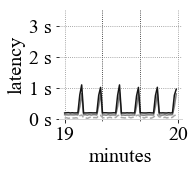

normalwindows
FLINK


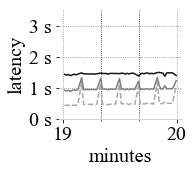

customwindows
KAFKASTREAMS


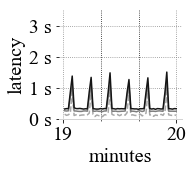

normalwindows
KAFKASTREAMS


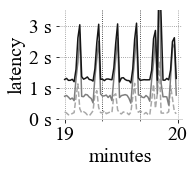

customwindows
STRUCTUREDSTREAMING


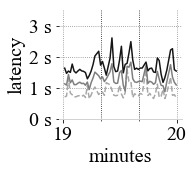

normalwindows
STRUCTUREDSTREAMING


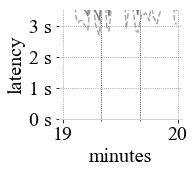

In [63]:
# frameworks=["FLINK"]
frameworksPrintable2 = {
    "SPARK": "Spark Str.", 
    "STRUCTUREDSTREAMING":"Structured Str.", 
    "FLINK": "Flink", 
    "KAFKASTREAMS": "Kafka Str."   
}

for framework in ["FLINK", "KAFKASTREAMS", "STRUCTUREDSTREAMING"]:
    for j, windowType in enumerate(windowTypes):
        print(windowType)
        print(framework)
        generateFlinkWindowingPeriodicBurstChart(j, \
                               latencyPandas=stageLatencyWindowingPandasShortSample[framework][windowType], \
                                start=start, end=end)

FLINK
+-----+-----------+
|burst|avgMsgCount|
+-----+-----------+
|    0|     5174.0|
|    1|     6789.0|
|    2|      335.0|
|    3|      123.0|
|    4|      119.0|
|    5|      120.0|
|    6|      120.0|
|    7|      119.0|
|    8|      120.0|
+-----+-----------+

+-----+--------------------+--------------------+
|burst|percentile_50_second|percentile_99_second|
+-----+--------------------+--------------------+
|    0|               292.0|               496.0|
|    1|               712.0|              1056.0|
|    2|               295.0|               462.0|
|    3|               125.0|               190.0|
|    4|               121.0|               189.0|
|    5|               122.0|               189.0|
|    6|               124.0|               189.0|
|    7|               124.0|               190.0|
|    8|               125.0|               190.0|
+-----+--------------------+--------------------+

KAFKASTREAMS
+-----+-----------+
|burst|avgMsgCount|
+-----+-----------+
|    0|  

/home/giselle-klarrio/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


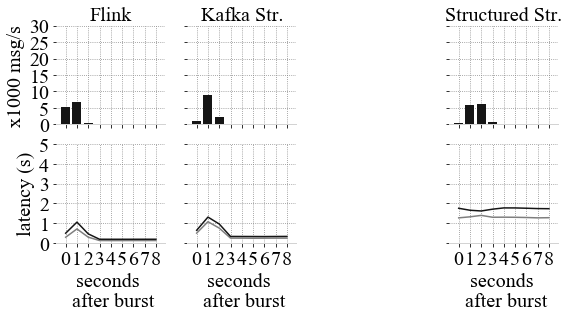

In [66]:
f, ax = plt.subplots(2, 4,figsize=(9, 4), sharey='row', sharex='col')
windowType = "customwindows"
file = open("./figures/periodic-burst/overall/phase" + str(NOTEBOOK_PHASE) + "/normalwindow_stats_phase" + str(NOTEBOOK_PHASE) + ".txt", 'w')
for i, framework in enumerate(["FLINK", "KAFKASTREAMS", "", "STRUCTUREDSTREAMING"]):
    try:
        print(framework)
        file.write(framework + "\n")
        throughputTimeseriesDataWithStartup = dict()

        outputtp = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPathWindows[framework][windowType] + "/output-throughput-timeseries-second-buckets.csv/*") \
            .withColumn("time", datetimeFromEpochUDF(col("outputBucketTime")))    

        inputtp = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPathWindows[framework][windowType] + "/input-throughput-timeseries-second-buckets.csv/*") \
            .withColumn("time", datetimeFromEpochUDF(col("inputBucketTime")))    

        inputBurstsColumn = inputtp.withColumn("realInputMsgCount",col("inputMsgCount")*inputfactor)\
            .filter(col("realInputMsgCount")>400).select("inputBucket")

        afterBurstsColumn1 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 1000).withColumn("burst", F.lit(1))
        afterBurstsColumn2 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 2000).withColumn("burst", F.lit(2))   
        afterBurstsColumn3 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 3000).withColumn("burst", F.lit(3))
        afterBurstsColumn4 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 4000).withColumn("burst", F.lit(4))
        afterBurstsColumn5 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 5000).withColumn("burst", F.lit(5))
        afterBurstsColumn6 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 6000).withColumn("burst", F.lit(6))
        afterBurstsColumn7 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 7000).withColumn("burst", F.lit(7))
        afterBurstsColumn8 = inputBurstsColumn.withColumn("inputBucket", col("inputBucket") + 8000).withColumn("burst", F.lit(8))

        timestampsOfInterest = inputBurstsColumn.withColumn("burst", F.lit(0))\
            .union(afterBurstsColumn1)\
            .union(afterBurstsColumn2)\
            .union(afterBurstsColumn3)\
            .union(afterBurstsColumn4)\
            .union(afterBurstsColumn5)\
            .union(afterBurstsColumn6)\
            .union(afterBurstsColumn7)\
            .union(afterBurstsColumn8).orderBy("inputBucket").withColumnRenamed("inputBucket", "outputBucketTime")

        outputTpAfterBurst = outputtp.join(timestampsOfInterest, "outputBucketTime")
        outputTpStats = outputTpAfterBurst.groupBy("burst").agg(F.avg("outputMsgCount").alias("avgMsgCount"))\
            .withColumn("avgMsgCount",  F.round(col("avgMsgCount")))\
            .orderBy("burst")
        outputTpStats.show()
        file.write(outputTpStats.toPandas().to_string(header = True, index = False) + "\n")
        outputTpPd = outputTpStats.toPandas()

        ax[0, i].bar(outputTpPd["burst"], outputTpPd["avgMsgCount"], color="#151515")
        ax[0, i].set_ylim(ymin=0, ymax=30000)
    #     minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    #     ax[0, i].yaxis.set_minor_locator(minor_y_locator_3)
        ax[0, i].grid(which='minor', color='black')
        ax[0, i].set_yticks([0, 5000, 10000, 15000, 20000, 25000, 30000])
        ax[0, i].set_xticks(np.arange(9))
        ax[0, i].get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ')))

        latencyAfterBurst = flinkWindowingLatency[framework][windowType].join(timestampsOfInterest, "outputBucketTime")
        latencyStats = latencyAfterBurst.groupBy("burst").agg(F.avg("percentile_50_second").alias("percentile_50_second"), avg("percentile_99_second").alias("percentile_99_second"))\
            .withColumn("percentile_50_second", F.round(col("percentile_50_second")))\
            .withColumn("percentile_99_second", F.round(col("percentile_99_second")))\
            .orderBy("burst")
        latencyPd = latencyStats.toPandas()
        latencyStats.show()
        file.write(latencyPd.to_string(header = True, index = False) + "\n")

        ax[1, i].plot(latencyPd["burst"], latencyPd["percentile_50_second"], color="#7e7e7e")
        ax[1, i].plot(latencyPd["burst"], latencyPd["percentile_99_second"], color="#151515")
        ax[1, i].set_xlabel("seconds \n after burst")
        ax[1, i].set_ylim(ymin=0, ymax=5000)
    #     minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    #     ax[1, i].yaxis.set_minor_locator(minor_y_locator_3)
        ax[1, i].grid(which='minor', color='black')
        ax[1, i].set_yticks([0, 1000, 2000, 3000, 4000, 5000])
        ax[1, i].set_xticks(np.arange(9))
        ax[1, i].get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ')))

        ax[0, i].annotate(frameworksPrintable2[framework], xy=(0.5, 1), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            size='medium', ha='center', va='baseline')
    except:
        print("not for empty")
ax[0, 0].set_ylabel("x1000 msg/s")  
ax[1, 0].set_ylabel("latency (s)") 
f.delaxes(ax[0,2])
f.delaxes(ax[1,2])
save_img_colored_and_grayscale("./figures/periodic-burst/overall/phase" + str(NOTEBOOK_PHASE) + "/" + windowType + "_averageburst-phase" + str(NOTEBOOK_PHASE))
f.show()
 
file.close()